<a href="https://colab.research.google.com/github/jedcheng/micromagnetic_std_problem4/blob/main/std_problem4_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import numpy as np
from numba import jit, njit, prange
# from scipy.fft import fftn, ifftn
from torch.fft import fftn, ifftn
import time
import torch
import math

def LLG(Mx, My, Mz, Hx, Hy, Hz, t, exch, dd,
        Hx0, Hx1, Hx2, Hx3,
        Hy0, Hy1, Hy2, Hy3,
        Hz0, Hz1, Hz2, Hz3,
        Ms, dt, prefactor1, prefactor2, alpha):


    Hx += exch / dd / dd * (Hx0 + Hx1 + Hx2 + Hx3 - 4 * Mx)  # calculation of exchange field
    Hy += exch / dd / dd * (Hy0 + Hy1 + Hy2 + Hy3 - 4 * My)
    Hz += exch / dd / dd * (Hz0 + Hz1 + Hz2 + Hz3 - 4 * Mz)

    if t < 4000:
        Hx += 100
        Hy += 100
        Hz += 100

    elif t < 6000:
        Hx += (6000 - t)/20
        Hy += (6000 - t)/20
        Hz += (6000 - t)/20

    elif t > 50000:
        Hx -= 19.576
        Hy += 3.422
        alpha = 0.02
        prefactor1 = (-0.221) * dt / (1 + alpha**2)
        prefactor2 = prefactor1 * alpha /Ms


    MxHx = My * Hz - Mz * Hy  # calculation of M x H
    MxHy = Mz * Hx - Mx * Hz
    MxHz = Mx * Hy - My * Hx

    # M = torch.tensor([Mx, My, Mz])
    # H = torch.tensor([Hx, Hy, Hz])
    # MxHx, MxHy, MxHz = torch.cross(M, H)


    deltaMx = prefactor1 * MxHx + prefactor2 * (My * MxHz - Mz * MxHy)  # calculation of deltaM
    deltaMy = prefactor1 * MxHy + prefactor2 * (Mz * MxHx - Mx * MxHz)
    deltaMz = prefactor1 * MxHz + prefactor2 * (Mx * MxHy - My * MxHx)

    Mx += deltaMx  # update M
    My += deltaMy
    Mz += deltaMz

    mag = torch.sqrt(Mx ** 2 + My ** 2 + Mz ** 2)  # normalization of M
    Mx = Mx / mag * Ms
    My = My / mag * Ms
    Mz = Mz / mag * Ms

    return Mx, My, Mz, Hx, Hy, Hz, prefactor1, prefactor2, alpha





def calcDemagTensor(nx, ny, nz, dd, Kxx, Kxy, Kxz, Kyy, Kyz, Kzz, prefactor):
    for K in prange(-nz + 1, nz):
        for J in prange(-ny + 1, ny):
            for I in prange(-nx + 1, nx):
                if I == 0 and J == 0 and K == 0:
                    continue
                L = I + nx
                M = J + ny
                N = K + nz
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            r = math.sqrt((I + i - 0.5) * (I + i - 0.5) * dd * dd + (J + j - 0.5) * (J + j - 0.5) * dd * dd + (K + k - 0.5) * (K + k - 0.5) * dd * dd)
                            Kxx[L, M, N] += (-1) ** (i + j + k) * math.atan((K + k - 0.5) * (J + j - 0.5) * dd / r / (I + i - 0.5))
                            Kxy[L, M, N] += (-1) ** (i + j + k) * math.log((K + k - 0.5) * dd + r)
                            Kxz[L, M, N] += (-1) ** (i + j + k) * math.log((J + j - 0.5) * dd + r)
                            Kyy[L, M, N] += (-1) ** (i + j + k) * math.atan((I + i - 0.5) * (K + k - 0.5) * dd / r / (J + j - 0.5))
                            Kyz[L, M, N] += (-1) ** (i + j + k) * math.log((I + i - 0.5) * dd + r)
                            Kzz[L, M, N] += (-1) ** (i + j + k) * math.atan((J + j - 0.5) * (I + i - 0.5) * dd / r / (K + k - 0.5))
                Kxx[L, M, N] *= prefactor
                Kxy[L, M, N] *= -prefactor
                Kxz[L, M, N] *= -prefactor
                Kyy[L, M, N] *= prefactor
                Kyz[L, M, N] *= -prefactor
                Kzz[L, M, N] *= prefactor

    return Kxx, Kxy, Kxz, Kyy, Kyz, Kzz



In [2]:
data_type = torch.float32
saving_step = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:


nx = 166  # number of cells on x direction
ny = 42
nz = 1
dd = 3  # cell volume = dd x dd x dd
dt = 5E-6  # timestep in nanoseconds
timesteps = 200000
alpha = 0.5  # damping constant to relax system to S-state
exchConstant = 1.3E-11 * 1E18  # nanometer/nanosecond units

mu_0 = 1.256636  # vacuum permeability, = 4 * pi / 10
Ms = 800  # saturation magnetization
exch = 2 * exchConstant / mu_0 / Ms / Ms
prefactor1 = (-0.221) * dt / (1 + alpha * alpha)
prefactor2 = prefactor1 * alpha / Ms

Mx = torch.full((nx, ny, nz), Ms, dtype=data_type, device=device)  # magnetization on x direction
My = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # magnetization on y direction
Mz = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # magnetization on z direction

deltaMx = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # change of magnetization on x direction
deltaMy = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # change of magnetization on y direction
deltaMz = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # change of magnetization on z direction
mag = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # magnitude of magnetization

Kxx = torch.zeros((nx * 2, ny * 2, nz * 2), dtype=data_type, device=device)  # Initialization of demagnetization tensor
Kxy = torch.zeros((nx * 2, ny * 2, nz * 2), dtype=data_type, device=device)
Kxz = torch.zeros((nx * 2, ny * 2, nz * 2), dtype=data_type, device=device)
Kyy = torch.zeros((nx * 2, ny * 2, nz * 2), dtype=data_type, device=device)
Kyz = torch.zeros((nx * 2, ny * 2, nz * 2), dtype=data_type, device=device)
Kzz = torch.zeros((nx * 2, ny * 2, nz * 2), dtype=data_type, device=device)
prefactor = 1 / (4 * torch.pi)





In [4]:
Kxx, Kxy, Kxz, Kyy, Kyz, Kzz = calcDemagTensor(nx, ny, nz, dd, Kxx, Kxy, Kxz, Kyy, Kyz, Kzz, prefactor)


In [5]:
Kxx_fft = fftn(Kxx)  # fast fourier transform of demag tensor
Kxy_fft = fftn(Kxy)
Kxz_fft = fftn(Kxz)
Kyy_fft = fftn(Kyy)
Kyz_fft = fftn(Kyz)
Kzz_fft = fftn(Kzz)

Hx_exch = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # exchange field on x direction
Hy_exch = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # exchange field on y direction
Hz_exch = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # exchange field on z direction


Hx0 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx1 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx2 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx3 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)

Hy0 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy1 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy2 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy3 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)

Hz0 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz1 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz2 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz3 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)

t_array = torch.zeros(int(timesteps/saving_step))
Mx_mean_array = torch.zeros(int(timesteps/saving_step))
My_mean_array = torch.zeros(int(timesteps/saving_step))
Mz_mean_array = torch.zeros(int(timesteps/saving_step))
t_taken_array = torch.zeros(int(timesteps/saving_step))

In [6]:
start_time = time.time()
print_start_time = time.time()
for t in range(timesteps):

    # Mx = torch.nn.functional.pad(Mx, ((0, nx), (0, ny), (0, nz)), mode='constant').astype(data_type)
    # My = torch.nn.functional.pad(My, ((0, nx), (0, ny), (0, nz)), mode='constant').astype(data_type)
    # Mz = torch.nn.functional.pad(Mz, ((0, nx), (0, ny), (0, nz)), mode='constant').astype(data_type)

    Mx = torch.nn.functional.pad(Mx, pad=(0, nz, 0, ny, 0, nx), mode='constant', value=0)
    My = torch.nn.functional.pad(My, pad=(0, nz, 0, ny, 0, nx), mode='constant', value=0)
    Mz = torch.nn.functional.pad(Mz, pad=(0, nz, 0, ny, 0, nx), mode='constant', value=0)


    Hx = ifftn(fftn(Mx) * Kxx_fft + fftn(My) * Kxy_fft + fftn(Mz) * Kxz_fft)  # calc demag field with fft
    Hy = ifftn(fftn(Mx) * Kxy_fft + fftn(My) * Kyy_fft + fftn(Mz) * Kyz_fft)
    Hz = ifftn(fftn(Mx) * Kxz_fft + fftn(My) * Kyz_fft + fftn(Mz) * Kzz_fft)

    Hx = torch.real(Hx[nx:(2 * nx), ny:(2 * ny), nz:(2 * nz)])  # truncation of demag field
    Hy = torch.real(Hy[nx:(2 * nx), ny:(2 * ny), nz:(2 * nz)])
    Hz = torch.real(Hz[nx:(2 * nx), ny:(2 * ny), nz:(2 * nz)])
    Mx = Mx[0:nx, 0:ny, 0:nz]  # truncation of Mx, remove zero padding
    My = My[0:nx, 0:ny, 0:nz]
    Mz = Mz[0:nx, 0:ny, 0:nz]

    Hx0[1:, :, :] = Mx[:-1, :, :]  # -x
    Hx0[0, :, :] = Hx0[1, :, :]
    Hx1[:-1, :, :] = Mx[1:, :, :]  # +x
    Hx1[-1, :, :] = Hx1[-2, :, :]

    Hx2[:, 1:, :] = Mx[:, :-1, :]  # -y
    Hx2[:, 0, :] = Hx2[:, 1, :]
    Hx3[:, :-1, :] = Mx[:, 1:, :]  # +y
    Hx3[:, -1, :] = Hx3[:, -2, :]

    Hy0[1:, :, :] = My[:-1, :, :]
    Hy0[0, :, :] = Hy0[1, :, :]
    Hy1[:-1, :, :] = My[1:, :, :]
    Hy1[-1, :, :] = Hy1[-2, :, :]

    Hy2[:, 1:, :] = My[:, :-1, :]
    Hy2[:, 0, :] = Hy2[:, 1, :]
    Hy3[:, :-1, :] = My[:, 1:, :]
    Hy3[:, -1, :] = Hy3[:, -2, :]

    Hz0[1:, :, :] = Mz[:-1, :, :]
    Hz0[0, :, :] = Hz0[1, :, :]
    Hz1[:-1, :, :] = Mz[1:, :, :]
    Hz1[-1, :, :] = Hz1[-2, :, :]

    Hz2[:, 1:, :] = Mz[:, :-1, :]
    Hz2[:, 0, :] = Hz2[:, 1, :]
    Hz3[:, :-1, :] = Mz[:, 1:, :]
    Hz3[:, -1, :] = Hz3[:, -2, :]

    Mx, My, Mz, Hx, Hy, Hz, prefactor1, prefactor2, alpha = LLG(Mx, My, Mz, Hx, Hy, Hz, t, exch, dd,
                                                                    Hx0, Hx1, Hx2, Hx3,
                                                                    Hy0, Hy1, Hy2, Hy3,
                                                                    Hz0, Hz1, Hz2, Hz3,
                                                                    Ms, dt, prefactor1, prefactor2, alpha)
    if t % saving_step == 0:

        MxMean = torch.mean(Mx)
        MyMean = torch.mean(My)
        MzMean = torch.mean(Mz)
        time_taken = time.time() - start_time


        output_index = int(t/saving_step)
        t_array[output_index] = t
        Mx_mean_array[output_index] = MxMean
        My_mean_array[output_index] = MyMean
        Mz_mean_array[output_index] = MzMean
        t_taken_array[output_index] = time_taken

        if t % (5*saving_step) == 0:
            print_time = time.time() - print_start_time
            print(f"t = {t}, MxMean = {MxMean}, MyMean = {MyMean}, MzMean = {MzMean}, time taken = {print_time}s")
            print_start_time = time.time()

        start_time = time.time()


t = 0, MxMean = 800.0, MyMean = 0.106080062687397, MzMean = -0.035360127687454224, time taken = 0.046056270599365234s
t = 5000, MxMean = 656.6430053710938, MyMean = 455.12786865234375, MzMean = 12.564736366271973, time taken = 10.30080246925354s
t = 10000, MxMean = 683.94189453125, MyMean = 403.4794616699219, MzMean = 18.712642669677734, time taken = 12.037276268005371s
t = 15000, MxMean = 712.5471801757812, MyMean = 340.0116271972656, MzMean = 15.159963607788086, time taken = 9.878321886062622s
t = 20000, MxMean = 731.9071655273438, MyMean = 287.8856201171875, MzMean = 12.014784812927246, time taken = 10.291906595230103s
t = 25000, MxMean = 744.5120239257812, MyMean = 245.52499389648438, MzMean = 9.57694149017334, time taken = 9.8180091381073s
t = 30000, MxMean = 752.6399536132812, MyMean = 211.74630737304688, MzMean = 7.517554759979248, time taken = 9.825874090194702s
t = 35000, MxMean = 757.9814453125, MyMean = 185.5334930419922, MzMean = 5.7782206535339355, time taken = 9.656303644

In [7]:
import pandas as pd

df = pd.DataFrame({'t': t_array,
                   'Mx_mean': Mx_mean_array,
                   'My_mean': My_mean_array,
                   'Mz_mean': Mz_mean_array,
                   't_taken': t_taken_array})

df.to_csv('std_problem4.csv', index=False)

In [8]:
# Compare with mumax3
# The script was taken from the website
# I slightly modified the cell size and cell count to match the simulation
df_mumax = pd.read_csv("std_prob4_mumax3.txt", sep='\t')

mumax_t = df_mumax['# t (s)'].to_numpy()
mumax_mx = df_mumax['mx ()'].to_numpy()
mumax_my = df_mumax['my ()'].to_numpy()
mumax_mz = df_mumax['mz ()'].to_numpy()


In [9]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [10]:
t_array_ns = t_array / timesteps / 1e9

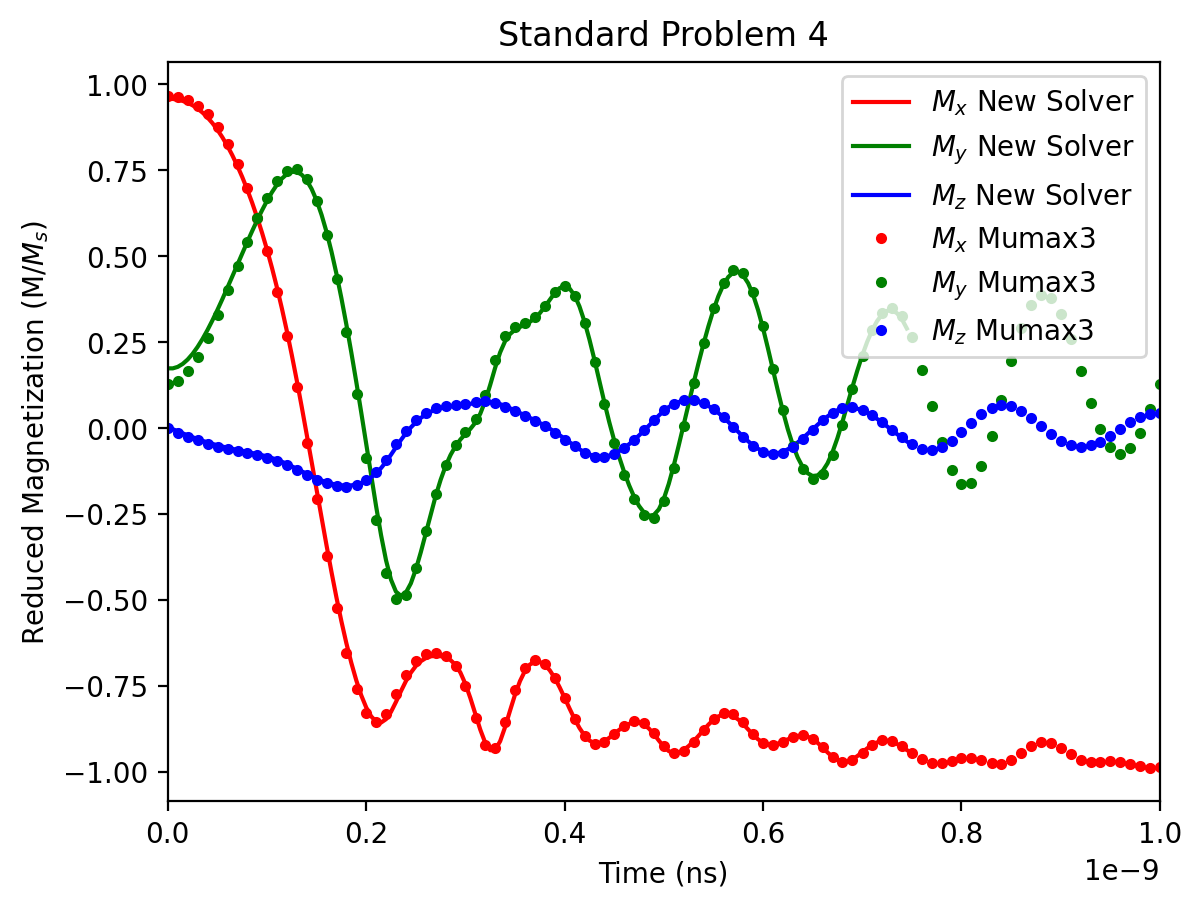

In [11]:
plt.plot(t_array_ns[50:] - t_array_ns[50] , Mx_mean_array[50:]/Ms, 'r', label='$M_x$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], My_mean_array[50:]/Ms, 'g', label='$M_y$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], Mz_mean_array[50:]/Ms, 'b', label='$M_z$ New Solver')
plt.plot(mumax_t, mumax_mx, 'r.', label='$M_x$ Mumax3')
plt.plot(mumax_t, mumax_my, 'g.', label='$M_y$ Mumax3')
plt.plot(mumax_t, mumax_mz, 'b.', label='$M_z$ Mumax3')
plt.xlim(0, 1e-9)

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Reduced Magnetization (M/$M_s$)')
plt.title('Standard Problem 4')
plt.savefig('std_prob4_mumax3.png', dpi=300)

I downloaded the last submitted results in the standard problem 4 site

https://www.ctcms.nist.gov/~rdm/mumag.org.html

asmus Bjørk, E. B. Poulsen and A. R. Insinga

In [12]:
df_magtense = pd.read_csv("std_problem4_magtense.csv", sep='\t')

In [13]:
magtense_t = df_magtense['%time[s]'].to_numpy()
magtense_mx = df_magtense['m_x'].to_numpy()
magtense_my = df_magtense['m_y'].to_numpy()
magtense_mz = df_magtense['m_z'].to_numpy()

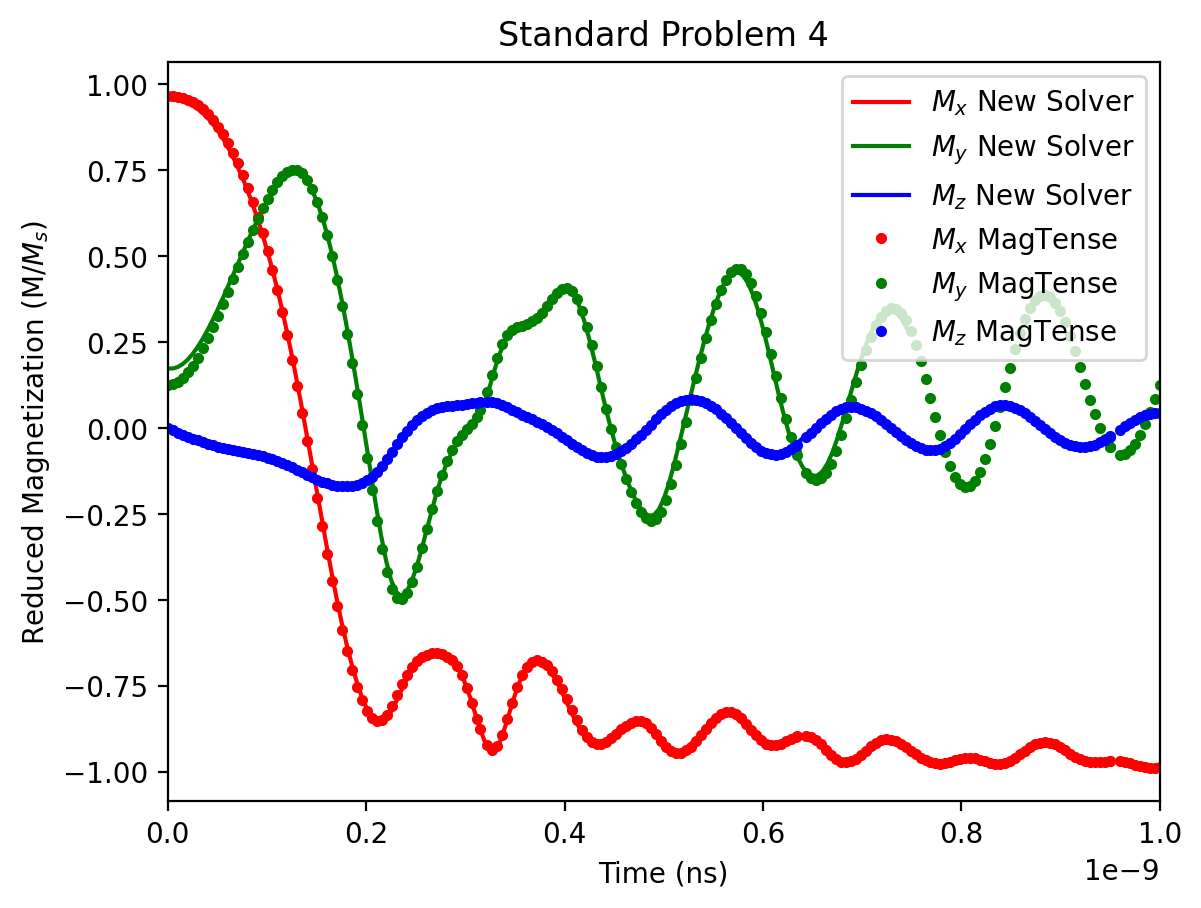

In [14]:
plt.plot(t_array_ns[50:] - t_array_ns[50] , Mx_mean_array[50:]/Ms, 'r', label='$M_x$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], My_mean_array[50:]/Ms, 'g', label='$M_y$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], Mz_mean_array[50:]/Ms, 'b', label='$M_z$ New Solver')
plt.plot(magtense_t, magtense_mx, 'r.', label='$M_x$ MagTense')
plt.plot(magtense_t, magtense_my, 'g.', label='$M_y$ MagTense')
plt.plot(magtense_t, magtense_mz, 'b.', label='$M_z$ MagTense')

plt.xlim(0, 1e-9)
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Reduced Magnetization (M/$M_s$)')
plt.title('Standard Problem 4')
plt.savefig('std_prob4_magtense.png', dpi=300)